In [1]:
'''A simple implementation of Daum's particle flow filter for the lorenz 96 equations.'''

from diffrax import diffeqsolve, ODETerm,ControlTerm
from jax.scipy.stats import norm
import diffrax
import jax.numpy as jnp
import numpy as np
import jax
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

In [2]:

t_vec = jnp.linspace(0,10,1000)

def lorenz_drift(t,X,args):

  F,noise = args

  return (jnp.roll(X, -1) - jnp.roll(X, 2)) * jnp.roll(X, 1) - X + F 


def lorenz_diffusion(t,X,args):

  _,noise = args

  return noise * jnp.eye(len(X))

In [3]:
'''The model integrator. Takes the length of time to integrate, the initial condition,prng key, and a parameter vector.'''
def model(ts,y0,par,key):
  key,w_key = jax.random.split(key)
  brownian_motion = diffrax.VirtualBrownianTree(ts[0],ts[-1], tol=1e-3, shape=(len(y0),), key=w_key)
  terms = diffrax.MultiTerm(ODETerm(lorenz_drift), ControlTerm(lorenz_diffusion, brownian_motion))

  solution = diffrax.diffeqsolve(
            terms,
            diffrax.Heun(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            args=par,
            saveat=diffrax.SaveAt(ts=ts),
              #At which points to save the output
        )
  return solution.ys


noise = 1.
key = jax.random.key(0)
key,sim_key = jax.random.split(key)
num_variables = 20
F = 8.


IC = jnp.ones(num_variables)
IC = IC.at[0].set(1.01)

'''Simulate model'''
X_true = model(t_vec,y0 = IC,par = (F,noise),key = sim_key)

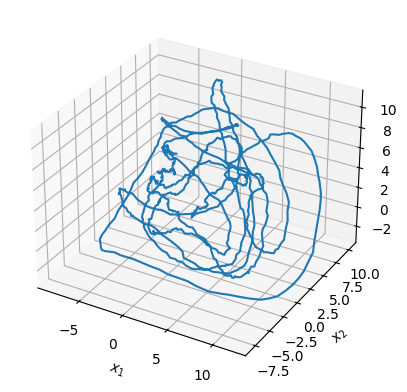

In [4]:
X = np.array(X_true)

# Plot the first three variables
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot(X[:, 0], X[:, 1], X[:, 2])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
plt.show()

In [5]:
'''Construct the observation operator'''
def OBS_OP(spacing,num_vars): 
    rows = num_vars//spacing
    HS = []
    
    one_hot_elem = 0
    for index in range(rows): 
        temp = jnp.zeros(num_vars)
        temp = temp.at[one_hot_elem].set(1)
        HS.append(temp)
        one_hot_elem += spacing

    return jnp.array(HS)



In [6]:
'''Observations will be every 5th variable'''
H = OBS_OP(5,num_variables)
OBS = X_true.T

OBS = H @ OBS


In [7]:
'''Now for the particle filter'''
num_particles = 100
key,init_key = jax.random.split(key)
delta_t = t_vec[1] - t_vec[0]
par_t_vec = jnp.linspace(0.,delta_t,10)
R_cov = (noise**2) * jnp.eye(H.shape[0])

particles = jax.random.normal(key = init_key, shape = (num_particles,num_variables))
weights = jnp.full((num_particles,),fill_value = np.log(1/num_particles))

model_lam = lambda y0,key: model(par_t_vec,y0 = y0,par = (F,noise),key = key)

vmap_model_lam = jax.jit(jax.vmap(model_lam,in_axes = (0,0)))

mean = jnp.zeros((len(t_vec),num_variables))
for step,observation in tqdm(enumerate(OBS.T)): 
    if step > 0: 
        key,sim_key = jax.random.split(key)
        sim_keys = jax.random.split(sim_key,num_particles)
        particles = vmap_model_lam(particles,sim_keys)[:,-1,:]

    weights = jax.scipy.stats.multivariate_normal.logpdf(x = observation,mean = (H @ particles.T).T,cov = R_cov)
    shifted_weights = weights - np.max(weights, keepdims=True)
    weights = weights-jax.scipy.special.logsumexp(weights)

    key,resample_key = jax.random.split(key)
    indices = jax.random.choice(resample_key,jnp.arange(num_particles),shape = (num_particles,),p = jnp.exp(weights))

    particles = particles[indices,:]

    mean = mean.at[step].set(jnp.mean(particles,axis = 0))


1000it [00:11, 90.86it/s]


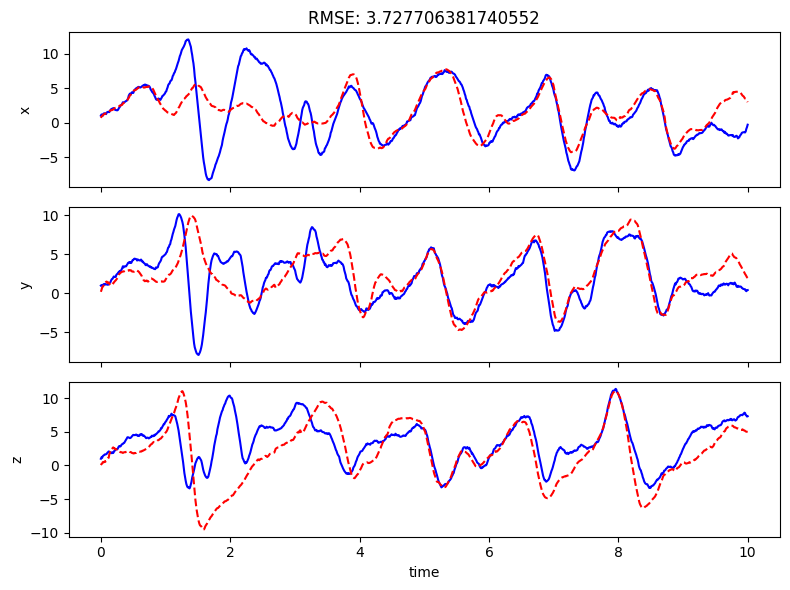

In [8]:
X = np.array(X_true)
PF_MEAN = np.array(mean)

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

rmse_pf = np.sqrt(mean_squared_error(X, PF_MEAN))

axes[0].set_title(f"RMSE: {rmse_pf}")
axes[0].plot(t_vec, X[:, 0],color = 'blue')
axes[0].plot(t_vec, PF_MEAN[:, 0],'--',color = 'red')
axes[0].set_ylabel("x")

axes[1].plot(t_vec, X[:, 1],color = 'blue')
axes[1].plot(t_vec, PF_MEAN[:, 1],'--',color = 'red')
axes[1].set_ylabel("y")

axes[2].plot(t_vec, X[:, 2],color = 'blue')
axes[2].plot(t_vec, PF_MEAN[:, 2],'--',color = 'red')
axes[2].set_ylabel("z")
axes[2].set_xlabel("time")

plt.tight_layout()
plt.show()

In [9]:
'''Now for the Ensemble Kalman filter'''
num_ensemble_members = 100
key,init_key = jax.random.split(key)
delta_t = t_vec[1] - t_vec[0]
par_t_vec = jnp.linspace(0.,delta_t,10)
R_cov = (noise**2) * jnp.eye(H.shape[0])
inflation = 1 * noise

members = jax.random.normal(key = init_key, shape = (num_ensemble_members,num_variables))

model_lam = lambda y0,key: model(par_t_vec,y0 = y0,par = (F,inflation),key = key)
vmap_model_lam = jax.jit(jax.vmap(model_lam,in_axes = (0,0)))

def kalman_update(member,key,obs,K): 
    eps = jax.random.multivariate_normal(key, mean = jnp.zeros(len(observation)),cov = R_cov)

    return member + K @ (obs - H@member + eps)

vmap_kalman_update = jax.jit(jax.vmap(kalman_update, in_axes = (0,0,None,None)))

ens_mean = jnp.zeros((len(t_vec),num_variables))
for step,observation in tqdm(enumerate(OBS.T)): 
    if step > 0: 
        key,sim_key = jax.random.split(key)
        sim_keys = jax.random.split(sim_key,num_ensemble_members)
        members = vmap_model_lam(members,sim_keys)[:,-1,:]

    m_prior = jnp.mean(members,axis = 0)
    cov_prior = jnp.cov(members.T)

    K = cov_prior @ H.T @ jnp.linalg.pinv(H @ cov_prior @ H.T + R_cov)

    key,eps_key = jax.random.split(key)
    eps_keys = jax.random.split(eps_key,num_ensemble_members)

    members = vmap_kalman_update(members,eps_keys,observation,K)

    ens_mean = ens_mean.at[step].set(jnp.mean(members,axis = 0))


0it [00:00, ?it/s]

1000it [00:06, 151.94it/s]


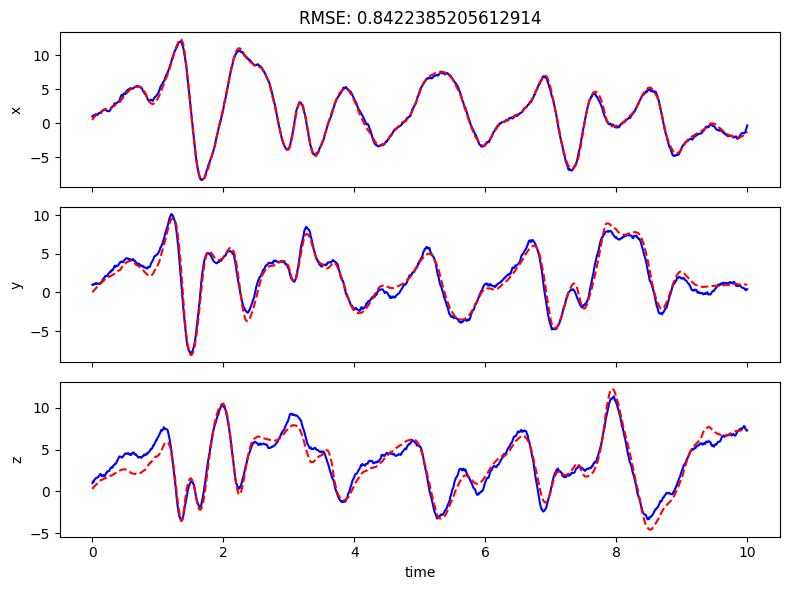

In [10]:
X = np.array(X_true)
ENKF_MEAN = np.array(ens_mean)

rmse_enkf = np.sqrt(mean_squared_error(X, ENKF_MEAN))

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

axes[0].set_title(f"RMSE: {rmse_enkf}")
axes[0].plot(t_vec, X[:, 0],color = 'blue')
axes[0].plot(t_vec, ENKF_MEAN[:, 0],'--',color = 'red')
axes[0].set_ylabel("x")

axes[1].plot(t_vec, X[:, 1],color = 'blue')
axes[1].plot(t_vec, ENKF_MEAN[:, 1],'--',color = 'red')
axes[1].set_ylabel("y")

axes[2].plot(t_vec, X[:, 2],color = 'blue')
axes[2].plot(t_vec, ENKF_MEAN[:, 2],'--',color = 'red')
axes[2].set_ylabel("z")
axes[2].set_xlabel("time")

plt.tight_layout()
plt.show()

In [11]:
# '''Now for the Ensemble Transform Kalman filter'''
# num_ensemble_members = 500
# key,init_key = jax.random.split(key)
# delta_t = t_vec[1] - t_vec[0]
# par_t_vec = jnp.linspace(0.,delta_t,10)
# R_cov = (noise**2) * jnp.eye(H.shape[0])
# R_inv = jnp.linalg.inv(R_cov)
# ones = jnp.ones(num_ensemble_members)[:,jnp.newaxis]

# members = jax.random.normal(key = init_key, shape = (num_ensemble_members,num_variables))

# model_lam = lambda y0,key: model(par_t_vec,y0 = y0,par = (F,noise),key = key)
# vmap_model_lam = jax.jit(jax.vmap(model_lam,in_axes = (0,0)))

# etkf_mean = jnp.zeros((len(t_vec),num_variables))
# for step,observation in tqdm(enumerate(OBS.T)): 
#     if step > 0: 
#         key,sim_key = jax.random.split(key)
#         sim_keys = jax.random.split(sim_key,num_ensemble_members)
#         members = vmap_model_lam(members,sim_keys)[:,-1,:]

#     X_bar_prior = jnp.mean(members.T, axis=1, keepdims=True)

#     X_hat_prior = members.T - X_bar_prior 

#     eigvals,Q = jnp.linalg.eigh(jnp.eye(num_ensemble_members) + 1/(num_ensemble_members -1) * (H @ X_hat_prior).T @ R_inv @ H @ X_hat_prior)

#     eigvals_inv = 1/eigvals * jnp.eye(len(eigvals))
#     eigvals_inv_sqrt = (eigvals**-1/2) * jnp.eye(len(eigvals))
    
#     K = 1/(num_ensemble_members -1) * X_hat_prior @ Q @ eigvals_inv @ Q.T @ (H @ X_hat_prior).T @ R_inv

#     X_bar_post = X_bar_prior + K @ (observation[:,jnp.newaxis] @ ones.T - H @ X_bar_prior) 
    
#     X_hat_post = X_hat_prior @ Q @ eigvals_inv_sqrt @ Q.T

#     X_post = X_bar_post + X_hat_post
#     members = X_post.T

#     etkf_mean = etkf_mean.at[step].set(jnp.mean(members,axis = 0))


In [12]:
# X = np.array(X_true)
# ETKF_MEAN = np.array(etkf_mean)

# rmse_etkf = np.sqrt(mean_squared_error(X, ETKF_MEAN))

# fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

# axes[0].set_title(f"RMSE: {rmse_etkf}")
# axes[0].plot(t_vec, X[:, 0],color = 'blue')
# axes[0].plot(t_vec, ETKF_MEAN[:, 0],'--',color = 'red')
# axes[0].set_ylabel("x")

# axes[1].plot(t_vec, X[:, 1],color = 'blue')
# axes[1].plot(t_vec, ETKF_MEAN[:, 1],'--',color = 'red')
# axes[1].set_ylabel("y")

# axes[2].plot(t_vec, X[:, 2],color = 'blue')
# axes[2].plot(t_vec, ETKF_MEAN[:, 2],'--',color = 'red')
# axes[2].set_ylabel("z")
# axes[2].set_xlabel("time")

# plt.tight_layout()
# plt.show()

In [13]:
def f(t,x,args):
    P_inv,H,R_inv,obs = args

    dx = -jnp.linalg.pinv(P_inv + t * (H.T @ R_inv @ H)) @ H.T @ R_inv @ (H @ x - obs)

    return dx


In [14]:
def particle_dynamics(ts,y0,par):

  solution = diffrax.diffeqsolve(
            ODETerm(f),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            args=par,
            max_steps=5000,
            stepsize_controller=diffrax.PIDController(rtol = 1e-3,atol = 1e-3)
        )
  return solution.ys

In [15]:
'''Now for the particle flow filter'''
num_particles = 100
key,init_key = jax.random.split(key)
delta_t = t_vec[1] - t_vec[0]
par_t_vec = jnp.linspace(0.,delta_t,10)
R_cov = (noise**2) * jnp.eye(H.shape[0])
R_inv = jnp.linalg.pinv(R_cov)

particles = jax.random.normal(key = init_key, shape = (num_particles,num_variables))
lams = jnp.linspace(0.,1.,2)

model_lam = lambda y0,key: model(par_t_vec,y0 = y0,par = (F,noise),key = key)
vmap_model_lam = jax.jit(jax.vmap(model_lam,in_axes = (0,0)))

vmap_dynamics = jax.jit(jax.vmap(particle_dynamics,in_axes = (None,0,None)))

pff_mean = jnp.zeros((len(t_vec),num_variables))
for step,observation in tqdm(enumerate(OBS.T)): 
    if step > 0: 
        key,sim_key = jax.random.split(key)
        sim_keys = jax.random.split(sim_key,num_particles)
        particles = vmap_model_lam(particles,sim_keys)[:,-1,:]

    P = jnp.cov(particles.T)
    x_pred = jnp.mean(particles,axis = 0)
    P_inv = jnp.linalg.inv(P)

    particles = vmap_dynamics(lams,particles,(P_inv,H,R_inv,observation))[:,-1,:]

    pff_mean = pff_mean.at[step].set(x_pred)


1000it [00:30, 33.06it/s]


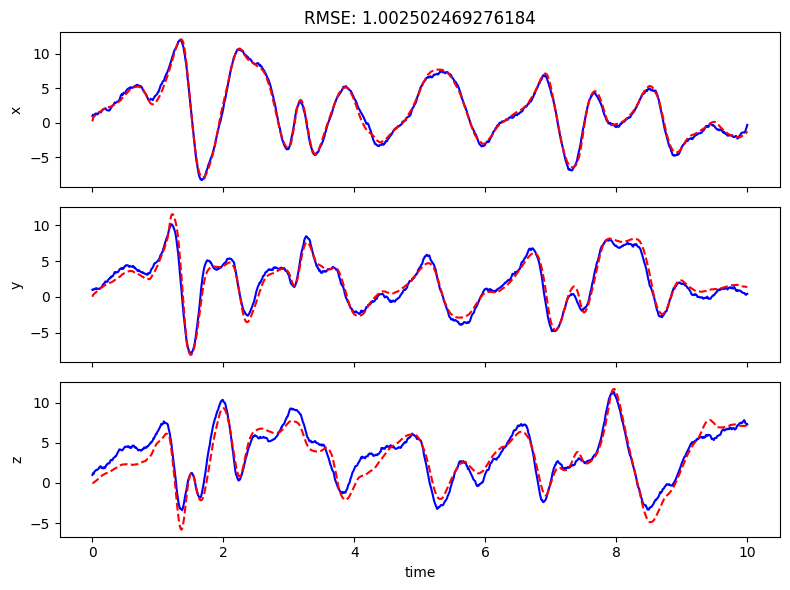

In [16]:
X = np.array(X_true)
PFF_MEAN = np.array(pff_mean)

rmse_pff = np.sqrt(mean_squared_error(X, PFF_MEAN))

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

axes[0].set_title(f"RMSE: {rmse_pff}")
axes[0].plot(t_vec, X[:, 0],color = 'blue')
axes[0].plot(t_vec, PFF_MEAN[:, 0],'--',color = 'red')
axes[0].set_ylabel("x")

axes[1].plot(t_vec, X[:, 1],color = 'blue')
axes[1].plot(t_vec, PFF_MEAN[:, 1],'--',color = 'red')
axes[1].set_ylabel("y")

axes[2].plot(t_vec, X[:, 2],color = 'blue')
axes[2].plot(t_vec, PFF_MEAN[:, 2],'--',color = 'red')
axes[2].set_ylabel("z")
axes[2].set_xlabel("time")

plt.tight_layout()
plt.show()